ETL for the Participation Excel:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def read_sheet(filename,sheetname):
    df = pd.read_excel(filename,sheet_name=sheetname,header=5)
    df.rename(columns={'Unnamed: 0':'division','Unnamed: 1':'title'},inplace=True)
    # remove referencing in the header and in divisions / states 
    df.columns=df.columns.str.replace(r'\([a-z]\)','')
    df['division']=df['division'].str.replace(r'\([a-z]\)','')
    # remove empty rows based on the value of the first 2 columns 
    df.dropna(subset=['division', 'title'], axis=0, how='all', inplace=True)
    # fill the rows with empty 'division' by using ffill
    df['division'].ffill(inplace=True)
    # create new column 'state' wherever title column is empty
    df.loc[df['title'].isnull(),'state'] = df['division']
    # fill the rows with empty 'state'     
    df['state'].ffill(inplace=True)
    # remove empty rows based on the value of the column Title
    df.dropna(subset=['title'], axis=0, inplace=True)
    # clean 'state' column by removing unnecessary wording 'Division'
    df['state'] = df['state'].str.replace('Divisions','').str.strip()
    # remove Totals to avoid double counting
    df = df[~df['division'].str.contains("Total")]
    return df

In [3]:
filename = "australian_marriage_law_postal_survey_2017_-_participation_final.xls"
df4 = read_sheet(filename,"Table 4")
df5 = read_sheet(filename,"Table 5")
df6 = read_sheet(filename,"Table 6")

df5['gender'] = 'Male'
df6['gender'] = 'Female'

# remove Totals to avoid double counting 
df5.drop(['Total Males'], axis=1, inplace=True)
df6.drop(['Total Females'], axis=1, inplace=True)

In [4]:
# adjust the structure of Table 4 to be able to merge it with the Tables 5 & 6
df4['gender'] = 'nfd'
df4['age-range'] = 'nfd'
df4.rename(columns={'Age and/or gender nfd.':'value'},inplace=True)
df4 = df4[['state','division','title','gender','age-range','value']]

In [5]:
# unpivoting Tables 5 & 6 
df5_melted = pd.melt(df5, id_vars = ['state','division','gender','title'], var_name = 'age-range', value_name = 'value')
df6_melted = pd.melt(df6, id_vars = ['state','division','gender','title'], var_name = 'age-range', value_name = 'value')

In [6]:
# contact the 3 tables into one consolidated table 
df = pd.concat([df4,df5_melted,df6_melted],axis=0)

In [7]:
# drop 'Participation rate (%)' to avoid adding the percentages 
df = df[df['title']!='Participation rate (%)']
df.head()

,state,division,title,gender,age-range,value
1,New South Wales,Banks,Total participants,nfd,nfd,480.0
2,New South Wales,Banks,Eligible participants,nfd,nfd,572.0
5,New South Wales,Barton,Total participants,nfd,nfd,396.0
6,New South Wales,Barton,Eligible participants,nfd,nfd,465.0
9,New South Wales,Bennelong,Total participants,nfd,nfd,480.0


In [8]:
#pivoting the dataframe to aggregate the details by Total and Eligible participants from the title column accross all other columns
df_pivot = df.pivot_table(index=['state','division','gender','age-range'],columns=['title'],values=['value']).reset_index()
df_pivot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4650 entries, 0 to 4649
Data columns (total 6 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   (state, )                       4650 non-null   object 
 1   (division, )                    4650 non-null   object 
 2   (gender, )                      4650 non-null   object 
 3   (age-range, )                   4650 non-null   object 
 4   (value, Eligible participants)  4650 non-null   float64
 5   (value, Total participants)     4650 non-null   float64
dtypes: float64(2), object(4)
memory usage: 218.1+ KB


In [9]:
df_pivot

state  ...              value
title                                ... Total participants
0      Australian Capital Territory  ...             2092.0
1      Australian Capital Territory  ...             5084.0
2      Australian Capital Territory  ...             5343.0
3      Australian Capital Territory  ...             5260.0
4      Australian Capital Territory  ...             4990.0
...                             ...  ...                ...
4645              Western Australia  ...             2550.0
4646              Western Australia  ...             1649.0
4647              Western Australia  ...             1148.0
4648              Western Australia  ...             1158.0
4649              Western Australia  ...              922.0

[4650 rows x 6 columns]

In [10]:
# fix the header of the pivoted dataframe
df_pivot.columns = [''.join(col).strip() for col in df_pivot.columns.values]
df_pivot.columns = df_pivot.columns.str.replace('value','')

In [11]:
df_pivot

,state,division,gender,age-range,Eligible participants,Total participants
0,Australian Capital Territory,Canberra,Female,18-19 years,2433.0,2092.0
1,Australian Capital Territory,Canberra,Female,20-24 years,6171.0,5084.0
2,Australian Capital Territory,Canberra,Female,25-29 years,6464.0,5343.0
3,Australian Capital Territory,Canberra,Female,30-34 years,6359.0,5260.0
4,Australian Capital Territory,Canberra,Female,35-39 years,6134.0,4990.0
...,...,...,...,...,...,...
4645,Western Australia,Tangney,Male,70-74 years,2783.0,2550.0
4646,Western Australia,Tangney,Male,75-79 years,1791.0,1649.0
4647,Western Australia,Tangney,Male,80-84 years,1257.0,1148.0
4648,Western Australia,Tangney,Male,85 years and over,1327.0,1158.0


In [12]:
df_pivot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4650 entries, 0 to 4649
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   state                  4650 non-null   object 
 1   division               4650 non-null   object 
 2   gender                 4650 non-null   object 
 3   age-range              4650 non-null   object 
 4   Eligible participants  4650 non-null   float64
 5   Total participants     4650 non-null   float64
dtypes: float64(2), object(4)
memory usage: 218.1+ KB


In [13]:
# Recreating Table 4

df_pivot.groupby(['state','age-range']).sum().reset_index()

,state,age-range,Eligible participants,Total participants
0,Australian Capital Territory,18-19 years,8605.0,6975.0
1,Australian Capital Territory,20-24 years,25566.0,19818.0
2,Australian Capital Territory,25-29 years,27266.0,21202.0
3,Australian Capital Territory,30-34 years,28902.0,22631.0
4,Australian Capital Territory,35-39 years,28033.0,22115.0
...,...,...,...,...
123,Western Australia,70-74 years,85126.0,75850.0
124,Western Australia,75-79 years,59694.0,53033.0
125,Western Australia,80-84 years,39945.0,34869.0
126,Western Australia,85 years and over,37206.0,30225.0


In [14]:
#Recreating Table 5 with grouping by state and age-range and filtering on gender as Male

df_pivot[df_pivot['gender']=='Male'].groupby(['state','age-range']).sum().reset_index()

,state,age-range,Eligible participants,Total participants
0,Australian Capital Territory,18-19 years,4164.0,3241.0
1,Australian Capital Territory,20-24 years,12825.0,9476.0
2,Australian Capital Territory,25-29 years,13569.0,9995.0
3,Australian Capital Territory,30-34 years,14331.0,10759.0
4,Australian Capital Territory,35-39 years,13943.0,10651.0
...,...,...,...,...
115,Western Australia,65-69 years,54504.0,47358.0
116,Western Australia,70-74 years,42161.0,37484.0
117,Western Australia,75-79 years,28500.0,25424.0
118,Western Australia,80-84 years,18066.0,15978.0


In [15]:
#Recreating Table 6 with grouping by state and age-range and filtering on gender as Female

df_pivot[df_pivot['gender']=='Female'].groupby(['state','age-range']).sum().reset_index()

,state,age-range,Eligible participants,Total participants
0,Australian Capital Territory,18-19 years,4441.0,3734.0
1,Australian Capital Territory,20-24 years,12741.0,10342.0
2,Australian Capital Territory,25-29 years,13697.0,11207.0
3,Australian Capital Territory,30-34 years,14571.0,11872.0
4,Australian Capital Territory,35-39 years,14090.0,11464.0
...,...,...,...,...
115,Western Australia,65-69 years,55782.0,49382.0
116,Western Australia,70-74 years,42965.0,38366.0
117,Western Australia,75-79 years,31194.0,27609.0
118,Western Australia,80-84 years,21879.0,18891.0


In [16]:
#After the recreating test, we have proof that the integrity of the dataset is not affected

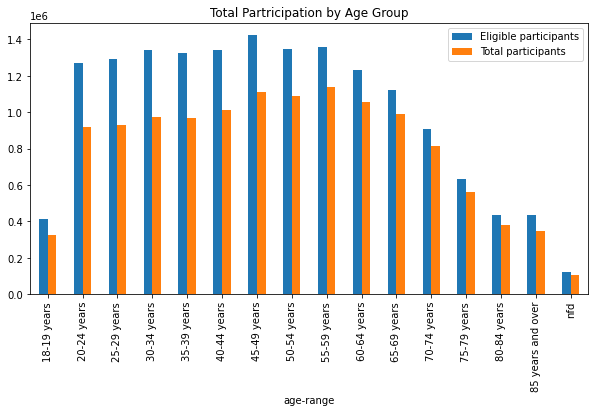

In [17]:
df_pivot.groupby(['age-range']).sum().plot(kind='bar',figsize=(10,5),title='Total Partricipation by Age Group')

In [18]:
#This graph shows that the age group of 45-49 years dominates on the number of both total and eligible participants

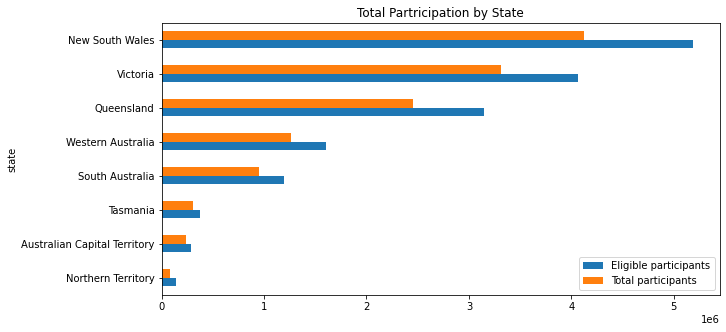

In [19]:
df_pivot.groupby(['state']).sum().sort_values('Total participants').plot(kind='barh',figsize=(10,5),title='Total Partricipation by State')

In [20]:
#This graph shows that the New South Wales states is the state with the highest eligible and total participants. The next contenders are Victoria and Queensland states

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f49703c94e0>],
      dtype=object)

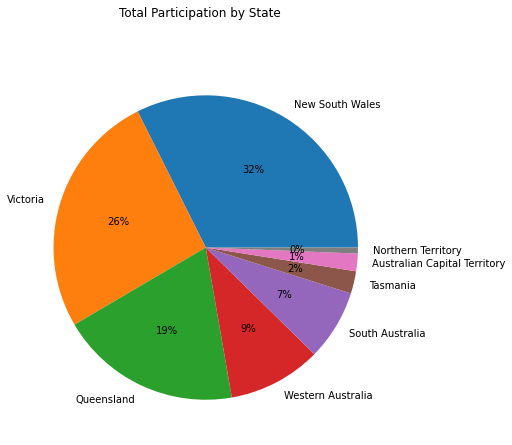

In [21]:
df_pivot[['state','Total participants']].groupby(['state']).sum().sort_values('Total participants',ascending=False).plot(kind='pie',figsize=(7,7),autopct='%1d%%',title='Total Participation by State',subplots=True,legend=False,ylabel='')

In [22]:
#This pie chart shows similar conclusions as the previous chart on the % of total participants per state

In [23]:
df_pivot.groupby(['gender','state']).sum()

Eligible participants  Total participants
gender state                                                                  
Female Australian Capital Territory               146228.0            123738.0
       New South Wales                           2641381.0           2147973.0
       Northern Territory                          67667.0             41088.0
       Queensland                                1606504.0           1286718.0
       South Australia                            606948.0            497531.0
       Tasmania                                   195163.0            159487.0
       Victoria                                  2077177.0           1736595.0
       Western Australia                          804269.0            651015.0
Male   Australian Capital Territory               138587.0            110992.0
       New South Wales                           2514193.0           1947545.0
       Northern Territory                          69588.0             38980.0
       Queensland                                1520894.0           1149465.0
       South Australia                            574439.0            443896.0
       Tasmania                                   181947.0            141006.0
       Victoria                                  1952526.0           1554203.0
       Western Australia                          783616.0            594045.0
nfd    Australian Capital Territory                 3293.0              2783.0
       New South Wales                             32107.0             26718.0
       Northern Territory                            846.0               537.0
       Queensland                                  23475.0             18980.0
       South Australia                             12193.0             10126.0
       Tasmania                                     2318.0              1915.0
       Victoria                                    31686.0             26957.0
       Western Australia                           19135.0             15627.0

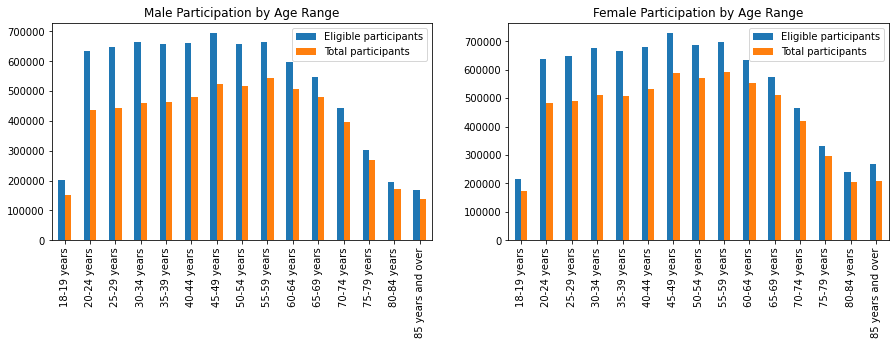

In [24]:
fig = plt.figure(figsize=(15,4))
ax1 = fig.add_subplot(1,2,1)
df_pivot[df_pivot['gender']=='Male'].groupby(['age-range']).sum().plot(ax=ax1,kind='bar', title='Male Participation by Age Range', xlabel='')
ax2 = fig.add_subplot(1,2,2)
df_pivot[df_pivot['gender']=='Female'].groupby(['age-range']).sum().plot(ax=ax2,kind='bar',title='Female Participation by Age Range', xlabel='')
plt.show()

In [25]:
#We wish to aggregagte in percent of the Total versus the Eligible participants between the Male and Female gender per age groups and each state.
df_participants_partition = pd.DataFrame()

df_male_participants = df_pivot[df_pivot['gender']=='Male'].groupby(['state','age-range']).sum()
df_participants_partition["Male Participants"] = df_male_participants["Total participants"]/df_male_participants["Eligible participants"]

df_female_participants = df_pivot[df_pivot['gender']=='Female'].groupby(['state','age-range']).sum()
df_participants_partition["Female Participants"] = df_female_participants["Total participants"]/df_female_participants["Eligible participants"]

df_participants_partition.groupby(['age-range','state']).sum()

Male Participants  Female Participants
age-range         state                                                               
18-19 years       Australian Capital Territory           0.778338             0.840802
                  New South Wales                        0.744585             0.800394
                  Northern Territory                     0.555219             0.619449
                  Queensland                             0.715456             0.782098
                  South Australia                        0.753996             0.819859
...                                                           ...                  ...
85 years and over Queensland                             0.834159             0.794790
                  South Australia                        0.831362             0.782462
                  Tasmania                               0.842745             0.792658
                  Victoria                               0.818847             0.778424
                  Western Australia                      0.841034             0.793881

[120 rows x 2 columns]

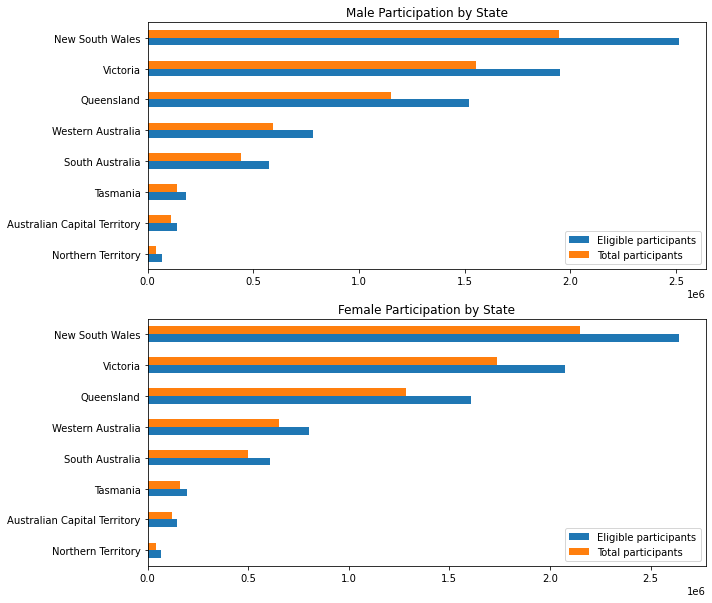

In [26]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(2,1,1)
df_pivot[df_pivot['gender']=='Male'].groupby(['state']).sum().sort_values('Total participants').plot(ax=ax1,kind='barh', title='Male Participation by State', xlabel='')
ax2 = fig.add_subplot(2,1,2)
df_pivot[df_pivot['gender']=='Female'].groupby(['state']).sum().sort_values('Total participants').plot(ax=ax2,kind='barh',title='Female Participation by State', xlabel='')
plt.show()

In [27]:
#The above graph shows that the number of eligible and total participants are higher on the female gender per state than the male

ETL for the Responses Excel file:


In [28]:
column_names = ["division", "yes", "no","not clear", "no response"]
# Many of the columns in this excel are repeated info from other columns and thus shall not be imported into the DataFrame
df_responses = pd.read_excel("australian_marriage_law_postal_survey_2017_-_response_final.xls", sheet_name="Table 2", usecols="A:B,D,K,M", names=column_names, skiprows = 6)

In [29]:
# the last eleven rows only include totals and do not have to be included into the dataframe
df_responses = df_responses[:-11]
# State and division are found under the same column, the following three lines treat this and create a new State column
df_responses.division.dropna(inplace=True)
df_responses.loc[df_responses['yes'].isnull(),"state/territory"] = df_responses['division']
df_responses["state/territory"].ffill(axis=0, inplace=True)
# We drop all remaining NaN values which pertain to rows which display totals
df_responses.dropna(how="any",axis=0, inplace=True)
# Remove states from the division column (they always include "Total")
df_responses = df_responses[~df_responses["division"].str.contains("Total")]
# States include "Divisions" at the end of the name and are treated here
df_responses["state/territory"] = df_responses["state/territory"].apply(lambda x: x[:-10])
# Unpivot the columns: yes, no, not clear and no respone.
df_responses = df_responses.melt(id_vars=["division", "state/territory"], var_name = 'answer', value_name = 'value')

In [30]:
df_responses.head()

,division,state/territory,answer,value
0,Banks,New South Wales,yes,37736.0
1,Barton,New South Wales,yes,37153.0
2,Bennelong,New South Wales,yes,42943.0
3,Berowra,New South Wales,yes,48471.0
4,Blaxland,New South Wales,yes,20406.0


In [31]:
#With some of transformations we can get to the end tables that are shown in the goverment website, for example %No and %Yes by state:
df_grouped_by_state = pd.pivot_table(df_responses, index=["state/territory"], columns = ["answer"], values=["value"])
df_grouped_by_state["population"] = df_grouped_by_state.sum(axis=1)

df_grouped_by_state["% No"] = df_grouped_by_state["value"]["no"]/df_grouped_by_state["population"]*100
df_grouped_by_state["% Yes"] = df_grouped_by_state["value"]["yes"]/df_grouped_by_state["population"]*100
df_grouped_by_state["% Participation rate"] = (df_grouped_by_state["% No"] + df_grouped_by_state["% Yes"])
df_grouped_by_state.drop(["value", "population"], axis = 1)

,% No,% Yes,% Participation rate
answer,,,
state/territory,,,
Australian Capital Territory,21.353104,60.900426,82.253530
New South Wales,33.480046,45.769237,79.249283
Northern Territory,22.946974,35.253908,58.200882
Queensland,30.499960,47.195174,77.695134
South Australia,29.846931,49.642923,79.489854
Tasmania,28.900081,50.588781,79.488862
Victoria,28.588692,52.829931,81.418623
Western Australia,28.370773,49.879591,78.250364


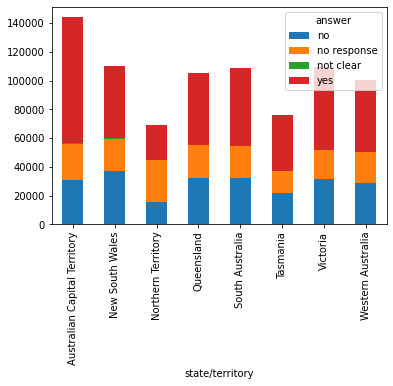

In [32]:
# It is nice to see values stacked to get an idea of proprtions of votes together with the population of each territory.
df_grouped_by_state["value"].plot(kind="bar", stacked=True)

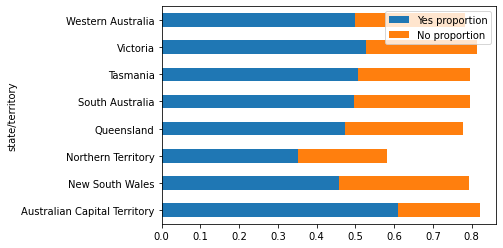

In [33]:
#Finally, we wish to visualize the ammount of yes and no votes with regards to the population so as to understand the proportion of yes/no votes in each state.
df_proportion = pd.DataFrame()

df_yes_propotion = df_responses[df_responses["answer"] == "yes"].groupby("state/territory").sum()
df_proportion["Yes proportion"] = df_yes_propotion["value"]/df_responses.groupby("state/territory").sum()["value"]

df_no_propotion = df_responses[df_responses["answer"] == "no"].groupby("state/territory").sum()
df_proportion["No proportion"] = df_no_propotion["value"]/df_responses.groupby("state/territory").sum()["value"]

df_proportion.plot(kind="barh", stacked=True)